In [1]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Function to get box scores for a given season
def get_box_scores(season):
    game_finder = leaguegamefinder.LeagueGameFinder(season_nullable=season)
    games = game_finder.get_data_frames()[0]
    return games

nba_teams = teams.get_teams()
team_id_to_code = {team['id']: team['abbreviation'] for team in nba_teams}

# Get a list of active NBA team IDs
nba_teams = teams.get_teams()
nba_team_ids = [team['id'] for team in nba_teams]

# List to store dataframes for each season
all_seasons_dataframes = []

# Seasons to fetch data for
seasons = ['2019-20','2020-21','2021-22', '2022-23', '2023-24']

# Fetch box scores for each season
for season in seasons:
    season_data = get_box_scores(season)
    all_seasons_dataframes.append(season_data)

# Concatenate dataframes for all seasons
all_games_df = pd.concat(all_seasons_dataframes, ignore_index=True)

# Filter data for only real NBA teams
all_games_df = all_games_df[all_games_df['TEAM_ID'].isin(nba_team_ids)]

# Convert the 'GAME_DATE' column to datetime
all_games_df['GAME_DATE'] = pd.to_datetime(all_games_df['GAME_DATE'])

# Create a new column indicating home or away game
all_games_df['HOME_AWAY'] = all_games_df['MATCHUP'].apply(lambda x: 'Home' if 'vs.' in x else 'Away')

# Define aggregation functions for each column
agg_df = all_games_df.groupby(['GAME_ID', 'TEAM_ID', 'HOME_AWAY']).agg({
    'GAME_DATE': 'max',  # Aggregate game date by taking the maximum date
    'MATCHUP':'max',
    'WL' : 'first', 
    'MIN': 'sum', 
    'PTS': 'sum', 
    'FGM': 'sum', 
    'FGA': 'sum', 
    'FG_PCT': 'mean',
    'FG3M': 'sum', 
    'FG3A': 'sum', 
    'FG3_PCT': 'mean', 
    'FTM': 'sum', 
    'FTA': 'sum', 
    'FT_PCT': 'mean', 
    'OREB': 'sum', 
    'DREB': 'sum', 
    'REB': 'sum', 
    'AST': 'sum', 
    'STL': 'sum', 
    'BLK': 'sum', 
    'TOV': 'sum', 
    'PF': 'sum', 
    'PLUS_MINUS': 'sum'
})

# Aggregate data by GAME_ID and TEAM_ID
#agg_df = all_games_df.groupby(['GAME_ID', 'TEAM_ID', 'HOME_AWAY']).agg(aggregation_functions)

# Flatten MultiIndex columns
agg_df.columns = ['{}_{}'.format(col[0], col[1]) for col in agg_df.columns]

# Reset index to flatten
agg_df.reset_index(inplace=True)

# Merge home and away data based on GAME_ID
merged_df = agg_df.merge(agg_df, on='GAME_ID')

# Filter out rows where the TEAM_IDs are the same (same team cannot play against itself)
merged_df = merged_df[merged_df['TEAM_ID_x'] != merged_df['TEAM_ID_y']]

# Filter out rows where HOME_AWAY_x is 'Away'
#merged_df = merged_df[merged_df['HOME_AWAY_x'] != 'Away']

# Replace 'W' with 1 and 'L' with 0 in the W_L_x column
merged_df['W_L_x'] = merged_df['W_L_x'].replace({'W': 1, 'L': 0})

merged_df = merged_df.drop(['W_L_y', 'GAME_ID','HOME_AWAY_x','HOME_AWAY_y','P_L_y', 'G_A_y', 'M_I_y', 'P_L_x','M_A_y'], axis=1)

merged_df['TEAM_ID_x'] = merged_df['TEAM_ID_x'].map(team_id_to_code)
merged_df['TEAM_ID_y'] = merged_df['TEAM_ID_y'].map(team_id_to_code)


merged_df.head()


,TEAM_ID_x,G_A_x,M_A_x,W_L_x,M_I_x,P_T_x,F_G_x,F_G_x,F_G_x,F_G_x,...,F_T_y,F_T_y,O_R_y,D_R_y,R_E_y,A_S_y,S_T_y,B_L_y,T_O_y,P_F_y
2,HOU,2019-10-04,HOU @ LAC,1,239,109,33,88,0.375,11,...,35,0.600,11,38,49,26,5,8,22,35
3,LAC,2019-10-04,LAC vs. HOU,0,239,96,33,86,0.384,9,...,40,0.800,12,40,52,21,11,5,20,29
6,IND,2019-10-04,IND @ SAC,1,264,132,48,93,0.516,10,...,36,0.778,6,24,30,30,8,4,22,31
7,SAC,2019-10-04,SAC vs. IND,0,264,131,44,89,0.494,15,...,33,0.788,14,33,47,26,11,3,24,29
11,IND,2019-10-05,IND vs. SAC,1,242,130,49,94,0.521,15,...,41,0.780,4,31,35,24,10,7,18,23


In [2]:
# Extract season information from game dates
def get_season(game_date):
    if game_date.month >= 10:  # NBA season typically starts in October
        return game_date.year
    else:
        return game_date.year - 1  # Season spans two calendar years

# Add season column to the DataFrame
merged_df['SEASON'] = merged_df['G_A_x'].apply(get_season)

# Display the resulting DataFrame with the season column
print(merged_df.head())

   TEAM_ID_x      G_A_x        M_A_x  W_L_x  M_I_x  P_T_x  F_G_x  F_G_x  \
2        HOU 2019-10-04    HOU @ LAC      1    239    109     33     88   
3        LAC 2019-10-04  LAC vs. HOU      0    239     96     33     86   
6        IND 2019-10-04    IND @ SAC      1    264    132     48     93   
7        SAC 2019-10-04  SAC vs. IND      0    264    131     44     89   
11       IND 2019-10-05  IND vs. SAC      1    242    130     49     94   

    F_G_x  F_G_x  ...  F_T_y  O_R_y  D_R_y  R_E_y  A_S_y  S_T_y  B_L_y  T_O_y  \
2   0.375     11  ...  0.600     11     38     49     26      5      8     22   
3   0.384      9  ...  0.800     12     40     52     21     11      5     20   
6   0.516     10  ...  0.778      6     24     30     30      8      4     22   
7   0.494     15  ...  0.788     14     33     47     26     11      3     24   
11  0.521     15  ...  0.780      4     31     35     24     10      7     18   

    P_F_y  SEASON  
2      35    2019  
3      29    2019  
6 

In [3]:
columnNames = ['TEAM_H', 'GAME_DATE','MATCHUP_H', 'WL_H', 'MIN', 
               'PTS_H', 'FGM_H', 'FGA_H', 'FG_PCT_H',
               'FG3M_H', 'FG3A_H', 'FG3_PCT_H', 'FTM_H', 'FTA_H', 
               'FT_PCT_H', 'OREB_H','DREB_H','REB_H', 'AST_H', 'STL_H', 
               'BLK_H', 'TOV_H', 'PF_H', 'TEAM_A','PTS_A', 'FGM_A', 'FGA_A', 
               'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A', 'FTM_A', 'FTA_A', 
               'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A', 
               'BLK_A', 'TOV_A', 'PF_A','SEASON']
merged_df.columns = columnNames


In [4]:
df = merged_df.sort_values("GAME_DATE")
df = df.reset_index(drop=True)
df.rename(columns={'WL_H': 'target'}, inplace=True)
df['home'] = df['MATCHUP_H'].str.contains('vs.').astype(int)

In [5]:
df = df.dropna()

In [6]:
#nulls = pd.isnull(df).sum()
#nulls = nulls[nulls > 0]
#valid_columns = df.columns[~df.columns.isin(nulls.index)]
#df = df[valid_columns].copy()

In [7]:
removed_columns = ["TEAM_H","GAME_DATE", "TEAM_A", "target", "SEASON", "MIN","PTS_H","PTS_A","MATCHUP_H", "FGM_H", "FGM_A"] 
selected_columns = df.columns[~df.columns.isin(removed_columns)]
selected_df = df.drop(columns=removed_columns)


## EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\augus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
df.shape

(13062, 44)

In [10]:
df["target"].value_counts()


1    6531
0    6531
Name: target, dtype: int64

In [11]:
df.describe()

,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,FG3M_H,FG3A_H,FG3_PCT_H,FTM_H,...,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,SEASON,home
count,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,...,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000,13062.000000
mean,0.500000,241.533609,112.334635,41.157327,88.358674,0.466768,12.502986,34.778135,0.358701,17.516996,...,10.226841,33.927193,44.154035,25.031159,7.564768,4.861660,13.449701,19.871765,2021.042719,0.500000
std,0.500019,6.740209,12.616851,5.264621,7.066674,0.055380,3.886643,6.902179,0.084374,5.901585,...,3.760363,5.501437,6.669613,5.043979,2.916870,2.483804,3.979240,4.255040,1.395909,0.500019
min,0.000000,196.000000,59.000000,21.000000,63.000000,0.269000,2.000000,10.000000,0.069000,2.000000,...,0.000000,16.000000,23.000000,8.000000,0.000000,0.000000,1.000000,6.000000,2019.000000,0.000000
25%,0.000000,240.000000,104.000000,38.000000,84.000000,0.429000,10.000000,30.000000,0.302000,13.000000,...,8.000000,30.000000,39.000000,22.000000,5.000000,3.000000,11.000000,17.000000,2020.000000,0.000000
50%,0.500000,240.000000,112.000000,41.000000,88.000000,0.466000,12.000000,34.000000,0.357000,17.000000,...,10.000000,34.000000,44.000000,25.000000,7.000000,5.000000,13.000000,20.000000,2021.000000,0.500000
75%,1.000000,241.000000,121.000000,45.000000,93.000000,0.505000,15.000000,39.000000,0.415000,21.000000,...,13.000000,38.000000,48.000000,28.000000,9.000000,6.000000,16.000000,23.000000,2022.000000,1.000000
max,1.000000,316.000000,176.000000,65.000000,121.000000,0.687000,29.000000,69.000000,0.720000,44.000000,...,29.000000,60.000000,74.000000,50.000000,22.000000,20.000000,30.000000,37.000000,2023.000000,1.000000


In [12]:
merged_df.iloc[3000]

TEAM_H                       NOP
GAME_DATE    2021-01-04 00:00:00
MATCHUP_H            NOP vs. IND
WL_H                           0
MIN                          265
PTS_H                        116
FGM_H                         44
FGA_H                        101
FG_PCT_H                   0.436
FG3M_H                         9
FG3A_H                        27
FG3_PCT_H                  0.333
FTM_H                         19
FTA_H                         24
FT_PCT_H                   0.792
OREB_H                        16
DREB_H                        41
REB_H                         57
AST_H                         26
STL_H                          5
BLK_H                          4
TOV_H                         18
PF_H                          20
TEAM_A                       IND
PTS_A                        118
FGM_A                         45
FGA_A                         93
FG_PCT_A                   0.484
FG3M_A                        19
FG3A_A                        45
FG3_PCT_A 

13.44970142397795

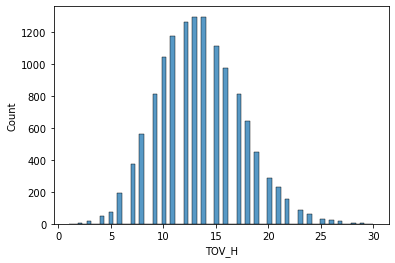

In [13]:
sns.histplot(df['TOV_H'])
df['TOV_H'].mean()

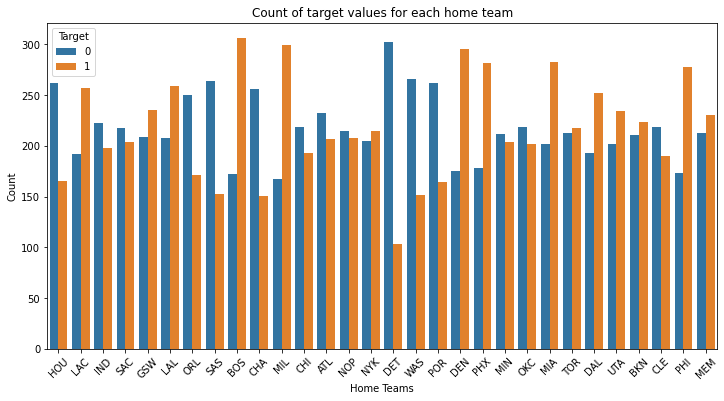

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='TEAM_H', hue='target', data=df)
plt.xlabel('Home Teams')
plt.ylabel('Count')
plt.title('Count of target values for each home team')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['0', '1']) # Assuming target values are 0 and 1
plt.show()

### Find Rolling Averages From All Teams

In [15]:
df_rolling = df[list(selected_columns) + ["target", "TEAM_H", "SEASON"]]

def find_team_averages(team):
    rolling = team.rolling(5).mean()
    return rolling

df_rolling = df_rolling.groupby(["TEAM_H", "SEASON"], group_keys=False).apply(find_team_averages)


C:\Users\augus\AppData\Local\Temp\ipykernel_7552\4164271589.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['TEAM_H'], dtype='object')
  rolling = team.rolling(5).mean()


In [16]:
rolling_cols = [f"{col}_5" for col in df_rolling.columns]
df_rolling.columns = rolling_cols
df = pd.concat([df, df_rolling], axis=1)

In [17]:
df = df.dropna()


In [18]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("TEAM_H", group_keys=False).apply(lambda x: shift_col(x, col_name))

df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "TEAM_A")
df["date_next"] = add_col(df, "GAME_DATE")
df

,TEAM_H,GAME_DATE,MATCHUP_H,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,FG3M_H,...,STL_A_5,BLK_A_5,TOV_A_5,PF_A_5,home_5,target_5,SEASON_5,home_next,team_opp_next,date_next
77,ORL,2019-10-13,ORL vs. PHI,0,242,94,34,87,0.391,8,...,10.2,4.0,22.6,20.4,0.4,0.6,2019.0,1.0,MIA,2019-10-17
98,LAL,2019-10-16,LAL vs. GSW,1,241,126,49,82,0.598,15,...,10.4,5.4,21.2,24.2,0.6,0.6,2019.0,0.0,GSW,2019-10-18
102,CHA,2019-10-16,CHA vs. DET,0,243,110,41,80,0.513,9,...,9.8,7.0,20.6,21.4,0.6,0.2,2019.0,1.0,CHI,2019-10-23
106,DET,2019-10-16,DET @ CHA,1,241,116,42,87,0.483,14,...,7.4,6.2,15.0,24.0,0.6,0.6,2019.0,0.0,IND,2019-10-23
112,DAL,2019-10-17,DAL @ LAC,1,240,102,35,78,0.449,15,...,8.8,4.8,18.6,25.0,0.4,0.4,2019.0,1.0,WAS,2019-10-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13059,POR,2024-04-14,POR @ SAC,0,240,82,31,98,0.316,7,...,9.2,6.8,11.8,15.6,0.6,0.0,2023.0,NaN,NaN,NaT
13060,NOP,2024-04-16,NOP vs. LAL,0,240,106,43,93,0.462,9,...,7.2,3.6,14.6,15.2,0.4,0.6,2023.0,NaN,NaN,NaT
13061,LAL,2024-04-16,LAL @ NOP,1,240,110,35,84,0.417,14,...,8.2,4.0,14.6,20.8,0.4,0.6,2023.0,NaN,NaN,NaT
13062,GSW,2024-04-16,GSW @ SAC,0,239,94,33,80,0.413,10,...,8.8,4.2,10.8,16.4,0.4,0.6,2023.0,NaN,NaN,NaT


In [19]:
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "TEAM_H"]], left_on=["TEAM_H", "date_next"], right_on=["team_opp_next", "date_next"])
full

,TEAM_H_x,GAME_DATE,MATCHUP_H,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,FG3M_H,...,AST_A_5_y,STL_A_5_y,BLK_A_5_y,TOV_A_5_y,PF_A_5_y,home_5_y,target_5_y,SEASON_5_y,team_opp_next_y,TEAM_H_y
0,CHA,2019-10-16,CHA vs. DET,0,243,110,41,80,0.513,9,...,28.0,8.6,6.0,21.0,20.4,0.6,0.4,2019.0,CHA,CHI
1,CHI,2019-10-17,CHI vs. ATL,1,242,111,41,93,0.441,15,...,24.0,9.8,7.0,20.6,21.4,0.6,0.2,2019.0,CHI,CHA
2,ATL,2019-10-17,ATL @ CHI,0,240,93,33,79,0.418,12,...,22.6,7.4,6.4,15.6,24.8,0.4,0.8,2019.0,ATL,DET
3,MIL,2019-10-17,MIL vs. MIN,1,238,118,43,84,0.512,11,...,27.0,11.0,5.2,21.2,27.6,0.4,0.6,2019.0,MIL,HOU
4,HOU,2019-10-18,HOU @ MIA,1,240,144,45,86,0.523,22,...,21.2,10.0,3.0,18.4,23.2,0.4,1.0,2019.0,HOU,MIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,CLE,2024-04-12,CLE vs. IND,1,241,129,50,95,0.526,13,...,32.2,9.6,3.4,12.4,19.0,0.6,0.4,2023.0,CLE,CHA
12360,LAL,2024-04-14,LAL @ NOP,1,241,124,48,87,0.552,11,...,28.6,7.0,3.8,16.0,16.2,0.2,0.8,2023.0,LAL,NOP
12361,NOP,2024-04-14,NOP vs. LAL,0,240,108,41,86,0.477,15,...,27.0,9.6,4.2,15.8,18.4,0.6,0.6,2023.0,NOP,LAL
12362,GSW,2024-04-14,GSW vs. UTA,1,239,123,45,94,0.479,14,...,23.2,7.6,4.2,15.4,16.6,0.6,0.4,2023.0,GSW,SAC


In [20]:
full[["TEAM_H_x", "team_opp_next_x", "TEAM_H_y", "team_opp_next_y", "date_next"]]

,TEAM_H_x,team_opp_next_x,TEAM_H_y,team_opp_next_y,date_next
0,CHA,CHI,CHI,CHA,2019-10-23
1,CHI,CHA,CHA,CHI,2019-10-23
2,ATL,DET,DET,ATL,2019-10-24
3,MIL,HOU,HOU,MIL,2019-10-24
4,HOU,MIL,MIL,HOU,2019-10-24
...,...,...,...,...,...
12359,CLE,CHA,CHA,CLE,2024-04-14
12360,LAL,NOP,NOP,LAL,2024-04-16
12361,NOP,LAL,LAL,NOP,2024-04-16
12362,GSW,SAC,SAC,GSW,2024-04-16


In [21]:
datetime_columns = list(df.select_dtypes(include=['datetime']).columns)

removed_columns_full = list(full.columns[full.dtypes == "object"]) + removed_columns + datetime_columns + list(df.columns)
removed_columns_full.append('target_5_x')

### EDA Extended

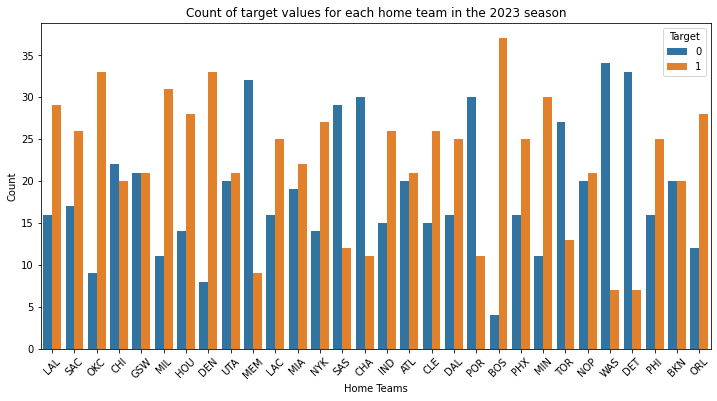

In [22]:
df_2023 = df[df['SEASON'] == 2023]
df_2023 = df_2023[df_2023['home']==1]
# Plotting count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='TEAM_H', hue='target', data=df_2023)
plt.xlabel('Home Teams')
plt.ylabel('Count')
plt.title('Count of target values for each home team in the 2023 season')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['0', '1']) # Assuming target values are 0 and 1
plt.show()

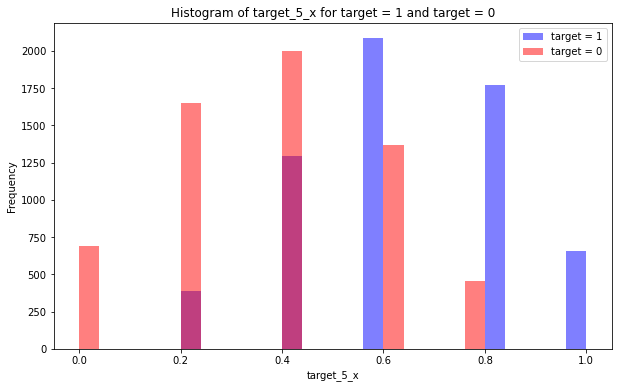

In [23]:
target_1_data = full[full['target'] == 1]['target_5_x']

# Filter data where 'target' = 0
target_0_data = full[full['target'] == 0]['target_5_x']

# Plotting histograms
plt.figure(figsize=(10, 6))

plt.hist(target_1_data, bins=20, alpha=0.5, color='blue', label='target = 1')
plt.hist(target_0_data, bins=20, alpha=0.5, color='red', label='target = 0')

plt.xlabel('target_5_x')
plt.ylabel('Frequency')
plt.title('Histogram of target_5_x for target = 1 and target = 0')
plt.legend()

plt.show()

### Test Model with Newly Refined Data

In [24]:
def backtest(data, model, predictors, start=3, step=1):
    all_predictions = []
    
    seasons = sorted(data["SEASON"].unique())
    
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train = data[data["SEASON"] < season]
        test = data[data["SEASON"] == season]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

#### Ridge

In [25]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

rr = RidgeClassifier(alpha=1)

split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, 
                                n_features_to_select=30, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

scaler = MinMaxScaler()
selected_columns = full.columns[~full.columns.isin(removed_columns_full)]

#selected_df = scaler.fit_transform(selected_df)
full[selected_columns] = scaler.fit_transform(full[selected_columns])

sfs.fit(full[selected_columns], full['target'])
predictors = list(selected_columns[sfs.get_support()])
predictors

['FG_PCT_H_5_x',
 'FG3M_H_5_x',
 'FTM_H_5_x',
 'FTA_H_5_x',
 'OREB_H_5_x',
 'TOV_H_5_x',
 'PF_H_5_x',
 'FGA_A_5_x',
 'FG_PCT_A_5_x',
 'FG3M_A_5_x',
 'FG3A_A_5_x',
 'FG3_PCT_A_5_x',
 'FTM_A_5_x',
 'OREB_A_5_x',
 'BLK_A_5_x',
 'TOV_A_5_x',
 'PF_A_5_x',
 'FGA_H_5_y',
 'FG_PCT_H_5_y',
 'FG3A_H_5_y',
 'FTM_H_5_y',
 'AST_H_5_y',
 'STL_H_5_y',
 'PF_H_5_y',
 'FG_PCT_A_5_y',
 'FG3A_A_5_y',
 'DREB_A_5_y',
 'AST_A_5_y',
 'STL_A_5_y',
 'TOV_A_5_y']

In [26]:
predictions = backtest(full, rr, predictors)


In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

accuracy_score(predictions["actual"], predictions["prediction"])


0.6818360914105595

In [28]:
confusion_matrix(predictions["actual"], predictions["prediction"])


array([[1742,  794],
       [ 821, 1719]], dtype=int64)

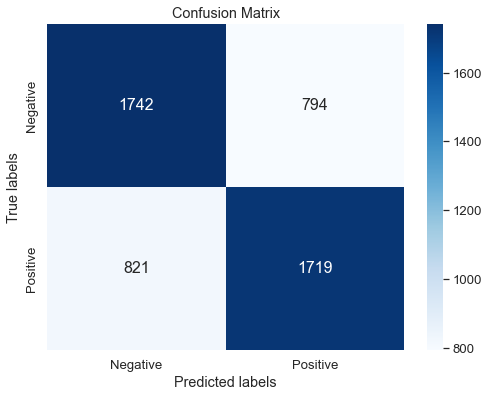

In [29]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(confusion_matrix(predictions["actual"], predictions["prediction"])
, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Adding labels, title, and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])  # Replace labels with your class names
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])  # Replace labels with your class names
plt.show()

In [30]:
f1_score(predictions["actual"], predictions["prediction"])


0.6803878883831386

In [31]:
print(classification_report(predictions["actual"], predictions["prediction"]))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      2536
           1       0.68      0.68      0.68      2540

    accuracy                           0.68      5076
   macro avg       0.68      0.68      0.68      5076
weighted avg       0.68      0.68      0.68      5076



#### Logistic

In [32]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()


sfs = SequentialFeatureSelector(lr, 
                                n_features_to_select=5, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

scaler = MinMaxScaler()
full[selected_columns] = scaler.fit_transform(full[selected_columns])

sfs.fit(full[selected_columns], full['target'])
predictors = list(selected_columns[sfs.get_support()])
predictors

['FG_PCT_H_5_x', 'OREB_H_5_x', 'FG_PCT_A_5_x', 'OREB_A_5_x', 'TOV_A_5_x']

In [33]:
predictions = backtest(full, lr, predictors)


In [34]:
accuracy_score(predictions["actual"], predictions["prediction"])

0.6609535066981875

In [35]:
confusion_matrix(predictions["actual"], predictions["prediction"])

array([[1718,  818],
       [ 903, 1637]], dtype=int64)

In [36]:
f1_score(predictions["actual"], predictions["prediction"])

0.6554554554554555

In [37]:
print(classification_report(predictions["actual"], predictions["prediction"]))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      2536
           1       0.67      0.64      0.66      2540

    accuracy                           0.66      5076
   macro avg       0.66      0.66      0.66      5076
weighted avg       0.66      0.66      0.66      5076



### Data Export

In [38]:
predictions

,actual,prediction
7288,0,0
7289,1,1
7290,0,0
7291,0,0
7292,1,1
...,...,...
12359,1,0
12360,1,1
12361,0,0
12362,1,1


In [39]:
df_export = full.iloc[7288:]

In [40]:
df_export.loc[:, 'predictions'] = predictions['prediction']

C:\Users\augus\AppData\Local\Temp\ipykernel_7552\1571616758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export.loc[:, 'predictions'] = predictions['prediction']


In [41]:
df_export['target'] = df_export['target'].replace({1: 'Win', 0: 'Loss'})
df_export['predictions'] = df_export['predictions'].replace({1: 'Win', 0: 'Loss'})


C:\Users\augus\AppData\Local\Temp\ipykernel_7552\1536686530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['target'] = df_export['target'].replace({1: 'Win', 0: 'Loss'})
C:\Users\augus\AppData\Local\Temp\ipykernel_7552\1536686530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['predictions'] = df_export['predictions'].replace({1: 'Win', 0: 'Loss'})


In [42]:
columnsToExport = ['GAME_DATE','MATCHUP_H','PTS_H','PTS_A','target','predictions']

In [43]:
df_export = df_export[columnsToExport]

In [44]:
df_export

,GAME_DATE,MATCHUP_H,PTS_H,PTS_A,target,predictions
7288,2022-10-12,CHA @ PHI,94,99,Loss,Loss
7289,2022-10-12,MIA vs. NOP,120,103,Win,Win
7290,2022-10-12,MIL vs. BKN,97,107,Loss,Loss
7291,2022-10-13,SAS vs. OKC,112,118,Loss,Loss
7292,2022-10-13,MEM @ DET,126,111,Win,Win
...,...,...,...,...,...,...
12359,2024-04-12,CLE vs. IND,129,120,Win,Loss
12360,2024-04-14,LAL @ NOP,124,108,Win,Win
12361,2024-04-14,NOP vs. LAL,108,124,Loss,Loss
12362,2024-04-14,GSW vs. UTA,123,116,Win,Win


In [45]:
df_export.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5076 entries, 7288 to 12363
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   GAME_DATE    5076 non-null   datetime64[ns]
 1   MATCHUP_H    5076 non-null   object        
 2   PTS_H        5076 non-null   int64         
 3   PTS_A        5076 non-null   int64         
 4   target       5076 non-null   object        
 5   predictions  5076 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 277.6+ KB


In [46]:
# Assuming 'df' is your DataFrame and 'datetime_column' is the column containing datetime64[ns] values
df_export['GAME_DATE'] = df_export['GAME_DATE'].dt.date


In [47]:
exportColumnNames = ['Game Date', 'Matchup', 'Home Score', 'Away Score', 'Home Team Outcome', 'Home Team Prediction']
df_export.columns = exportColumnNames


In [48]:
#df_export.to_csv('nbaGamePredHistory.csv', index=False)